In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Dim. reduction / Feature Selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Evaluation Metrics
from sklearn import metrics

### Load the dataset

In [2]:
fires = pd.read_csv("./forestfires.csv")
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 15 columns):
X              517 non-null int64
Y              517 non-null int64
month          517 non-null object
day            517 non-null object
FFMC           517 non-null float64
DMC            517 non-null float64
DC             517 non-null float64
ISI            517 non-null float64
temp           517 non-null float64
RH             517 non-null int64
wind           517 non-null float64
rain           517 non-null float64
area           517 non-null float64
log(area+1)    517 non-null float64
sin(area)      517 non-null float64
dtypes: float64(10), int64(3), object(2)
memory usage: 60.7+ KB


***

# EDA

## Statistical Data

In [3]:
fires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log(area+1),sin(area)
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.849724,1.113449,0.087751
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655327,1.396509,0.520179
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000024,0.000024,-0.999749
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.005617,0.005601,0.001004
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.418710,0.006572
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,2.024193,0.398609
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,6.995620,0.999958


## Correlation

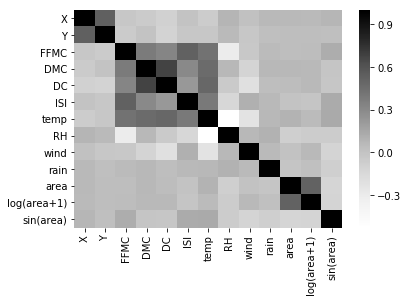

In [4]:
sns.heatmap(fires.corr(), cmap="Greys");

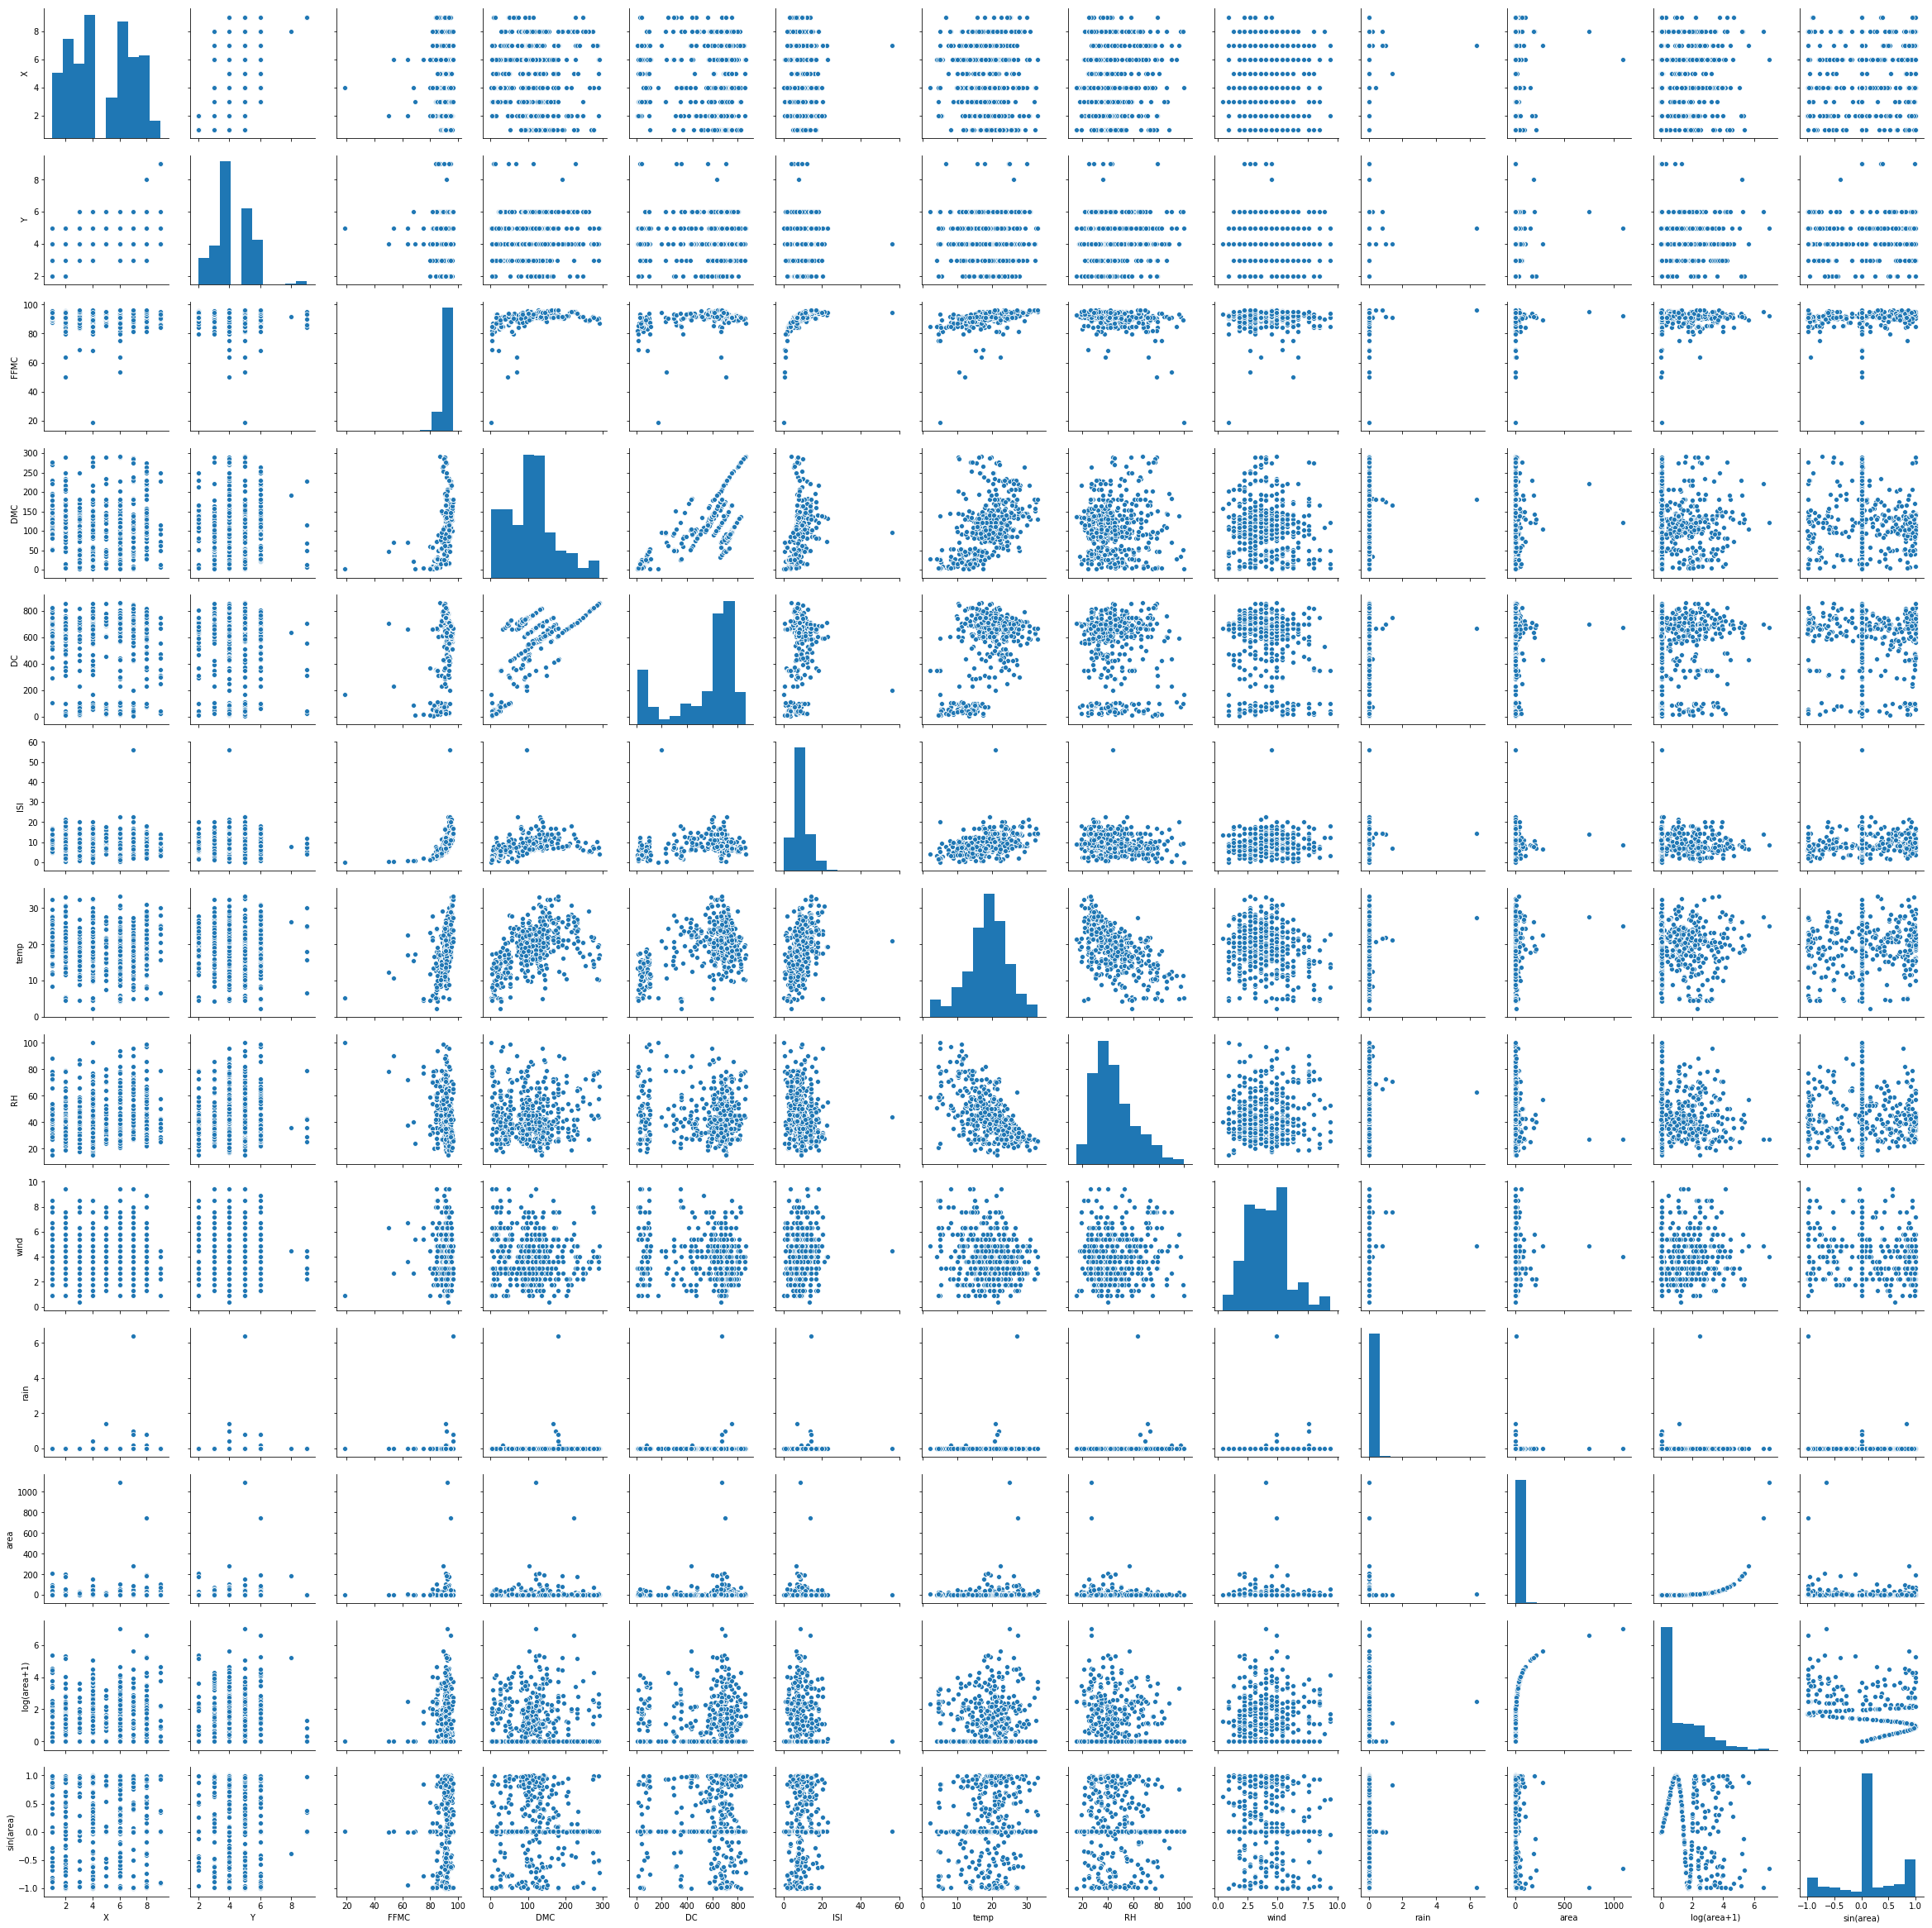

In [5]:
sns.pairplot(fires);

## Area distribution

/Users/victor/.local/share/virtualenvs/firewall-npje4pOc/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


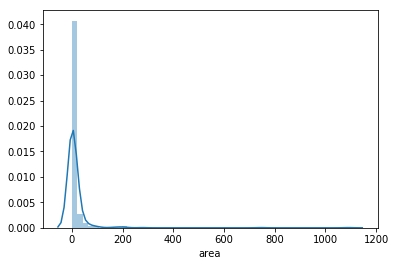

In [6]:
sns.distplot(
    fires["area"]
);

### log(area+1) distribution

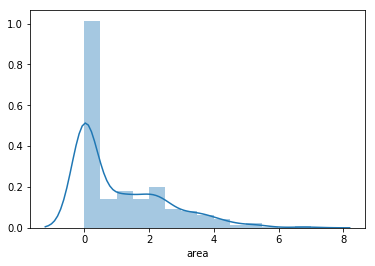

In [7]:
sns.distplot(
    np.log(fires["area"]+1)
);

In [8]:
fires["log(area+1)"] = np.log(fires["area"]+1)

### sin(area) distribution

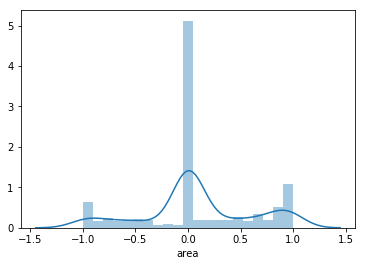

In [9]:
sns.distplot(
    np.sin(fires["area"])
);

In [10]:
fires["sin(area)"] = np.sin(fires["area"])

## New Correlation

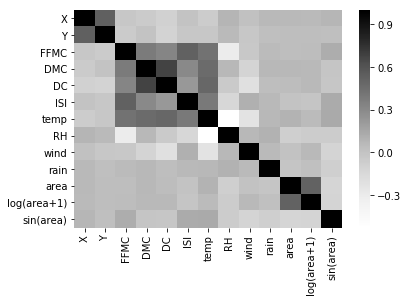

In [11]:
sns.heatmap(fires.corr(), cmap="Greys");

## Months / Days

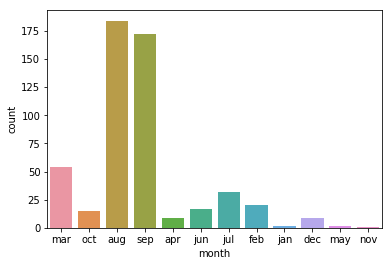

In [12]:
sns.countplot(fires["month"]);

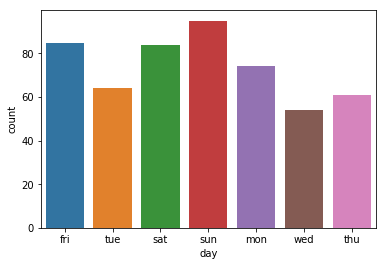

In [13]:
sns.countplot(fires["day"]);

***

# Preprocessing

## Splitting

In [14]:
X, y_raw, y_log, y_sin = (
    fires.drop(["area", "log(area+1)", "sin(area)"], axis=1),
    fires["area"],
    fires["log(area+1)"],
    fires["sin(area)"],
)

## Encoding

In [15]:
month_enc = LabelEncoder().fit(X["month"])
day_enc = LabelEncoder().fit(X["day"])

X["month"] = month_enc.transform(X["month"])
X["day"] = day_enc.transform(X["day"])

## Feature Selection

### Select Transformed y

In [16]:
y_tf = y_log

### Recursive Feature Elimination

In [17]:
rfe = RFE(
    RandomForestRegressor(n_estimators=100),
    n_features_to_select=5,
)

rfe.fit(X, y_tf);

N Selected Features: 5


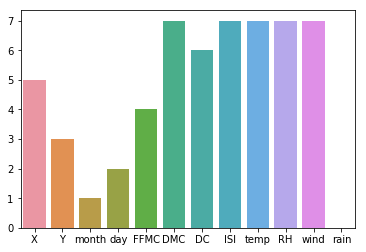

In [18]:
max_rank = max(rfe.ranking_)

print("N Selected Features:", rfe.n_features_)
sns.barplot(X.columns, max_rank-rfe.ranking_);

### Decision Tree Regressor

In [19]:
tree = DecisionTreeRegressor().fit(X, y_tf)

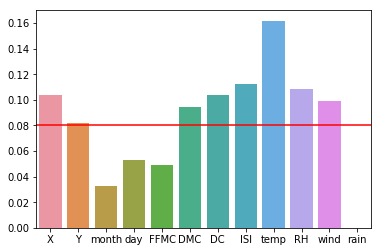

In [20]:
sns.barplot(X.columns, tree.feature_importances_)
plt.axhline(0.08, c='r');

***

## Evaluating Dummy models

In [21]:
dummy_y = y_tf

### 1. Dummy model (predicting always 0.00)

In [22]:
print("NEG_RMSE:", -np.sqrt(metrics.mean_squared_error(dummy_y, np.zeros_like(dummy_y))))
print("NEG_MAE:", -metrics.mean_absolute_error(dummy_y, np.zeros_like(dummy_y)))

NEG_RMSE: -1.7850028154917024
NEG_MAE: -1.1134494081386341


### 2. Dummy model (predicting always 1.00)

In [23]:
print("NEG_RMSE:", -np.sqrt(metrics.mean_squared_error(dummy_y, np.ones_like(dummy_y))))
print("NEG_MAE:", -metrics.mean_absolute_error(dummy_y, np.ones_like(dummy_y)))

NEG_RMSE: -1.3997629210105678
NEG_MAE: -1.1350269727112452


### 3. Dummy model (predicting always the mean of `y`)

In [24]:
y_pred = np.array([np.mean(dummy_y) for _ in range(dummy_y.size)])

print("NEG_RMSE:", -np.sqrt(metrics.mean_squared_error(dummy_y, y_pred)))
print("NEG_MAE:", -metrics.mean_absolute_error(dummy_y, y_pred))

NEG_RMSE: -1.3951578644830953
NEG_MAE: -1.155366679261826
